# LSTM Stock Prediction Framework - Jupyter Notebook
# Version 1.0 - Interactive Analysis

# Cell 1: Installation & Imports


In [3]:
"""
Run this cell first to install required packages (if needed):

%pip install numpy pandas yfinance ta scikit-learn tensorflow joblib matplotlib
"""

'\nRun this cell first to install required packages (if needed):\n\n%pip install numpy pandas yfinance ta scikit-learn tensorflow joblib matplotlib\n'

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ All libraries imported successfully!
TensorFlow version: 2.20.0


# Cell 2: Configuration Parameters

In [2]:
TICKER = 'AAPL'
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'
WINDOW_SIZE = 60
TRAIN_SPLIT_PERCENT = 0.8
EPOCHS = 50
BATCH_SIZE = 32
TARGET = 'log_return'
FEATURES = ['Close', 'Volume', 'RSI', 'MACD', 'EMA_20']
NUM_FEATURES = len(FEATURES)

print("=" * 80)
print("CONFIGURATION")
print("=" * 80)
print(f"Ticker: {TICKER}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Window Size: {WINDOW_SIZE}")
print(f"Train Split: {TRAIN_SPLIT_PERCENT * 100}%")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Features: {FEATURES}")
print(f"Number of Features: {NUM_FEATURES}")
print("=" * 80)

CONFIGURATION
Ticker: AAPL
Date Range: 2015-01-01 to 2024-12-31
Window Size: 60
Train Split: 80.0%
Epochs: 50
Batch Size: 32
Features: ['Close', 'Volume', 'RSI', 'MACD', 'EMA_20']
Number of Features: 5


# Cell 3: Data Ingestion & Feature Engineering

In [4]:
print("\n📥 Downloading stock data...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)

# Fix for yfinance MultiIndex columns issue
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

print(f"✅ Downloaded {len(df)} days of data")
print(f"Date range: {df.index[0]} to {df.index[-1]}")

# Display first few rows
print("\nFirst 5 rows of raw data:")
display(df.head())

# Calculate logarithmic returns
print("\n📊 Calculating logarithmic returns...")
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

# Calculate technical indicators
print("📈 Computing technical indicators...")
# Convert to Series to avoid shape issues
close_series = df['Close'].squeeze()
df['RSI'] = ta.momentum.RSIIndicator(close_series).rsi()
df['MACD'] = ta.trend.MACD(close_series).macd()
df['EMA_20'] = ta.trend.EMAIndicator(close_series, window=20).ema_indicator()

# Clean data
df_clean = df.dropna()
print(f"✅ Data cleaned. Shape: {df_clean.shape}")

# Display data with features
print("\nData with technical indicators:")
display(df_clean[['Close', 'Volume', 'RSI', 'MACD', 'EMA_20', 'log_return']].tail(10))


📥 Downloading stock data...
✅ Downloaded 2515 days of data
Date range: 2015-01-02 00:00:00 to 2024-12-30 00:00:00

First 5 rows of raw data:


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.261044,24.729267,23.821668,24.718171,212818400
2015-01-05,23.577572,24.110148,23.391171,24.030261,257142000
2015-01-06,23.579796,23.839426,23.218087,23.641929,263188400
2015-01-07,23.910439,24.010296,23.677436,23.788389,160423600
2015-01-08,24.829126,24.886823,24.121244,24.238856,237458000



📊 Calculating logarithmic returns...
📈 Computing technical indicators...
✅ Data cleaned. Shape: (2490, 9)

Data with technical indicators:


Price,Close,Volume,RSI,MACD,EMA_20,log_return
Date,,,,,,
2024-12-16,250.151978,51694800,78.747839,5.408432,240.072166,0.011659
2024-12-17,252.583344,51356400,80.923028,5.726545,241.263707,0.009673
2024-12-18,247.172562,56774100,64.983027,5.478890,241.826455,-0.021655
2024-12-19,248.906403,60882300,67.211809,5.360732,242.500736,0.006990
2024-12-20,253.589783,147495300,72.334144,5.580671,243.556835,0.018641
2024-12-23,254.367035,40858800,73.085632,5.751393,244.586378,0.003060
2024-12-24,257.286652,23234700,75.750242,6.052511,245.795928,0.011413
2024-12-26,258.103729,27237100,76.452846,6.284635,246.968100,0.003171
2024-12-27,254.685883,42355300,67.626272,6.122230,247.703127,-0.013331


# Cell 4: Data Visualization


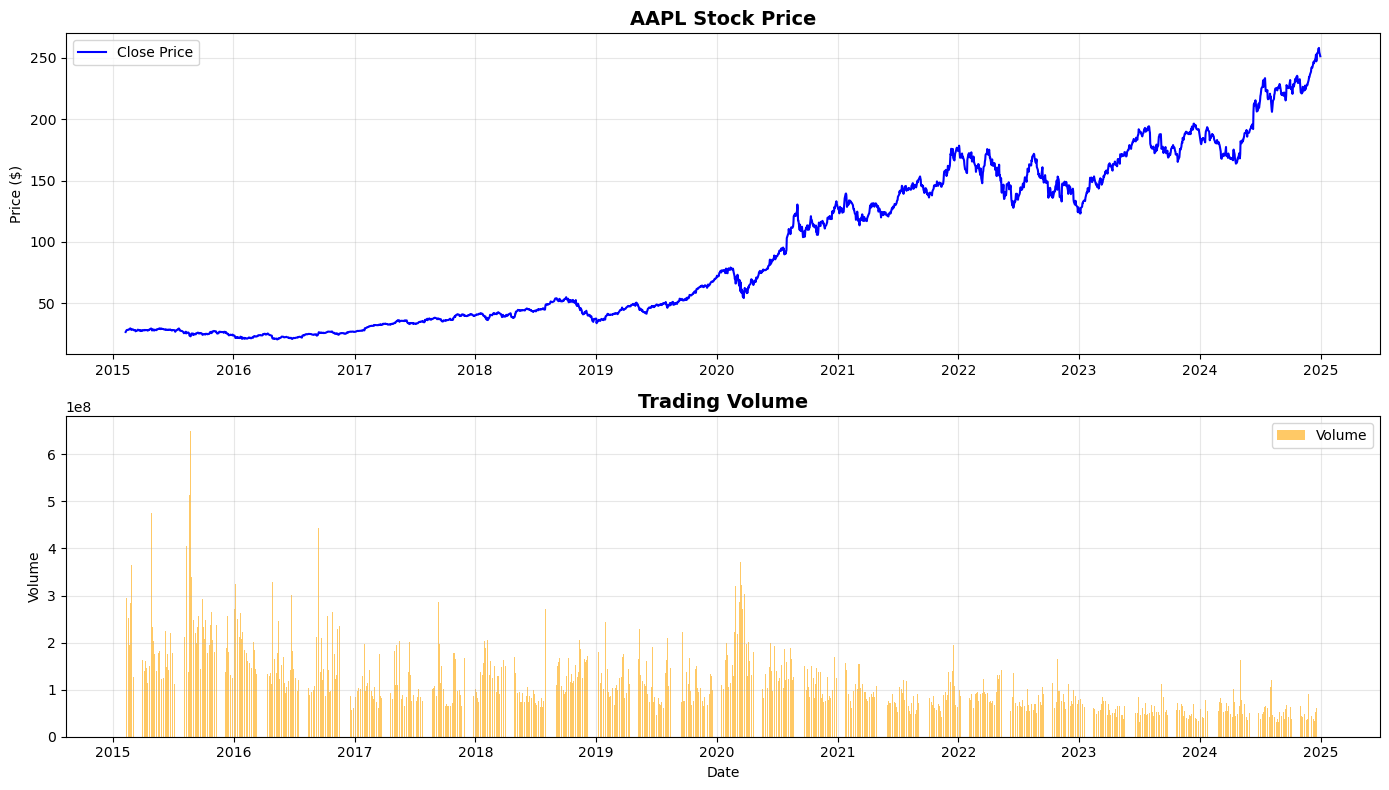

In [5]:
# Plot 1: Stock Price and Volume
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.plot(df_clean.index, df_clean['Close'], label='Close Price', color='blue')
ax1.set_title(f'{TICKER} Stock Price', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(df_clean.index, df_clean['Volume'], label='Volume', color='orange', alpha=0.6)
ax2.set_title('Trading Volume', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

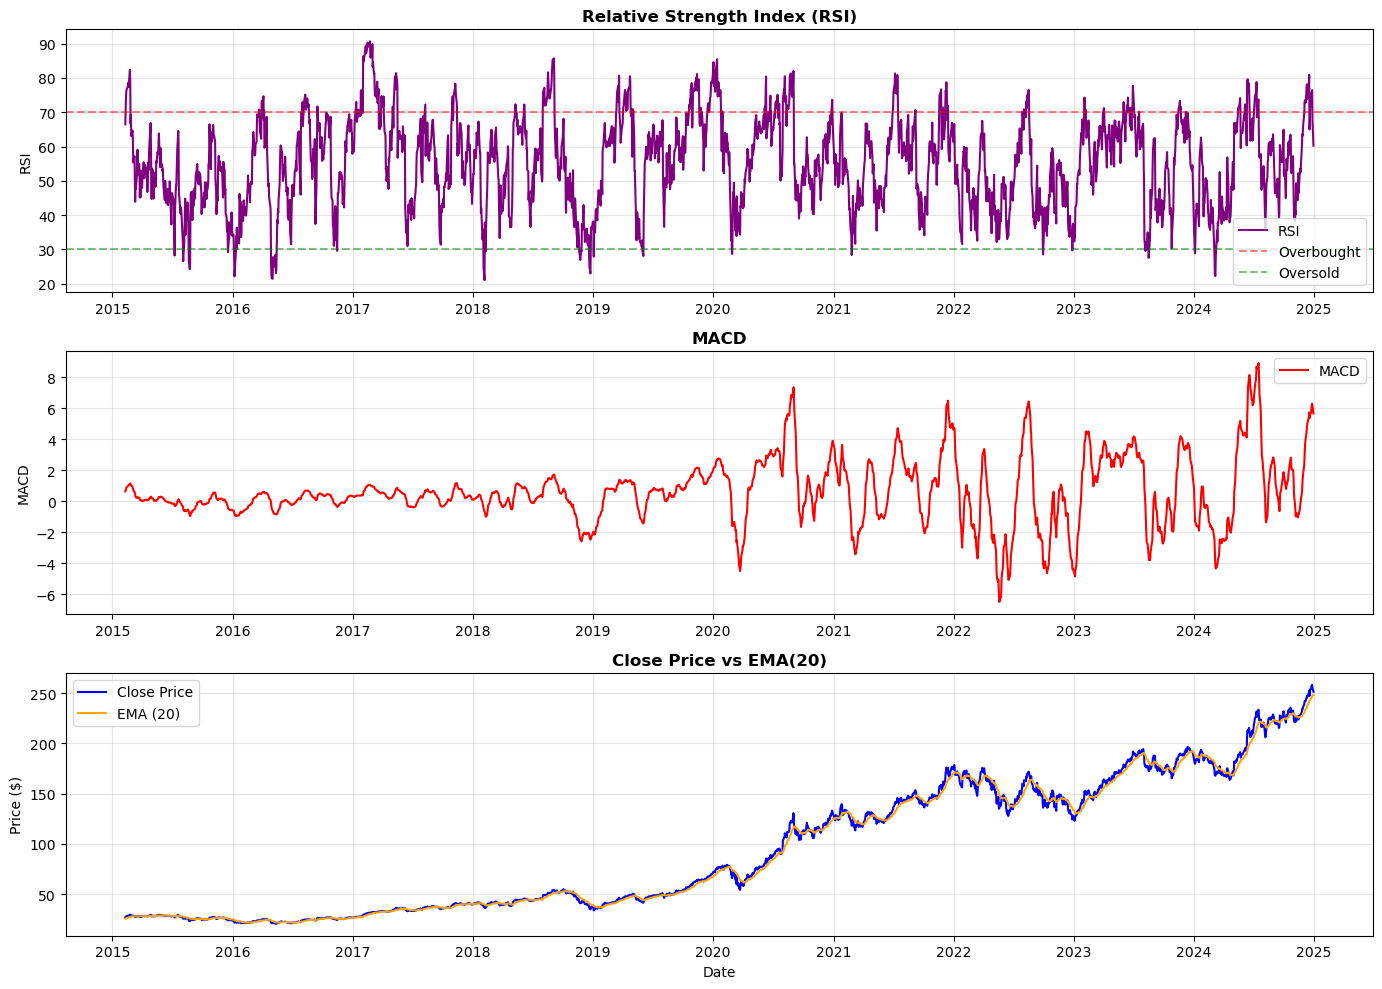

In [6]:
# Plot 2: Technical Indicators
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(df_clean.index, df_clean['RSI'], label='RSI', color='purple')
axes[0].axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought')
axes[0].axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RSI')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_clean.index, df_clean['MACD'], label='MACD', color='red')
axes[1].set_title('MACD', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MACD')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(df_clean.index, df_clean['Close'], label='Close Price', color='blue')
axes[2].plot(df_clean.index, df_clean['EMA_20'], label='EMA (20)', color='orange')
axes[2].set_title('Close Price vs EMA(20)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Price ($)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

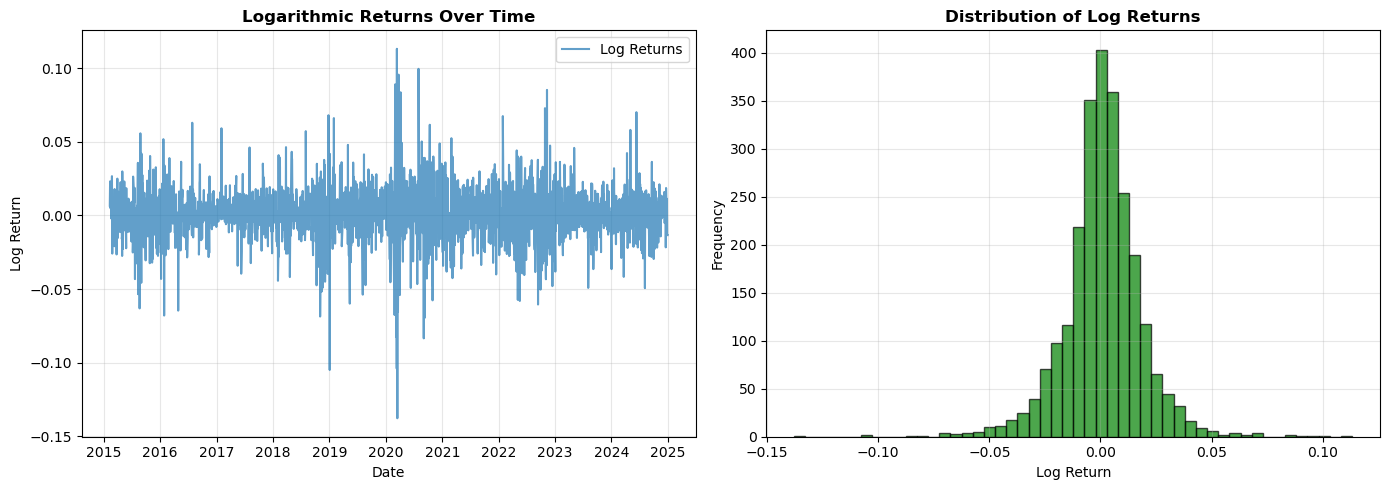


Log Return Statistics:
count    2490.000000
mean        0.000903
std         0.017898
min        -0.137708
25%        -0.007345
50%         0.000970
75%         0.010083
max         0.113157
Name: log_return, dtype: float64


In [7]:
# Plot 3: Log Returns Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(df_clean.index, df_clean['log_return'], label='Log Returns', alpha=0.7)
ax1.set_title('Logarithmic Returns Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.hist(df_clean['log_return'], bins=50, alpha=0.7, color='green', edgecolor='black')
ax2.set_title('Distribution of Log Returns', fontsize=12, fontweight='bold')
ax2.set_xlabel('Log Return')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLog Return Statistics:")
print(df_clean['log_return'].describe())


# Cell 5: Data Preprocessing & Scaling


In [8]:
print("\n🔧 Preprocessing & Scaling...")

# Extract features and target
feature_data = df_clean[FEATURES].values
target_data = df_clean[TARGET].values.reshape(-1, 1)

print(f"Feature data shape: {feature_data.shape}")
print(f"Target data shape: {target_data.shape}")

# Two-Scaler Strategy
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform
scaled_features = scaler_features.fit_transform(feature_data)
scaled_target = scaler_target.fit_transform(target_data)

print("✅ Data scaled successfully")

# Save scalers
joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_target, 'scaler_target.pkl')
print("✅ Scalers saved to disk")


🔧 Preprocessing & Scaling...
Feature data shape: (2490, 5)
Target data shape: (2490, 1)
✅ Data scaled successfully
✅ Scalers saved to disk


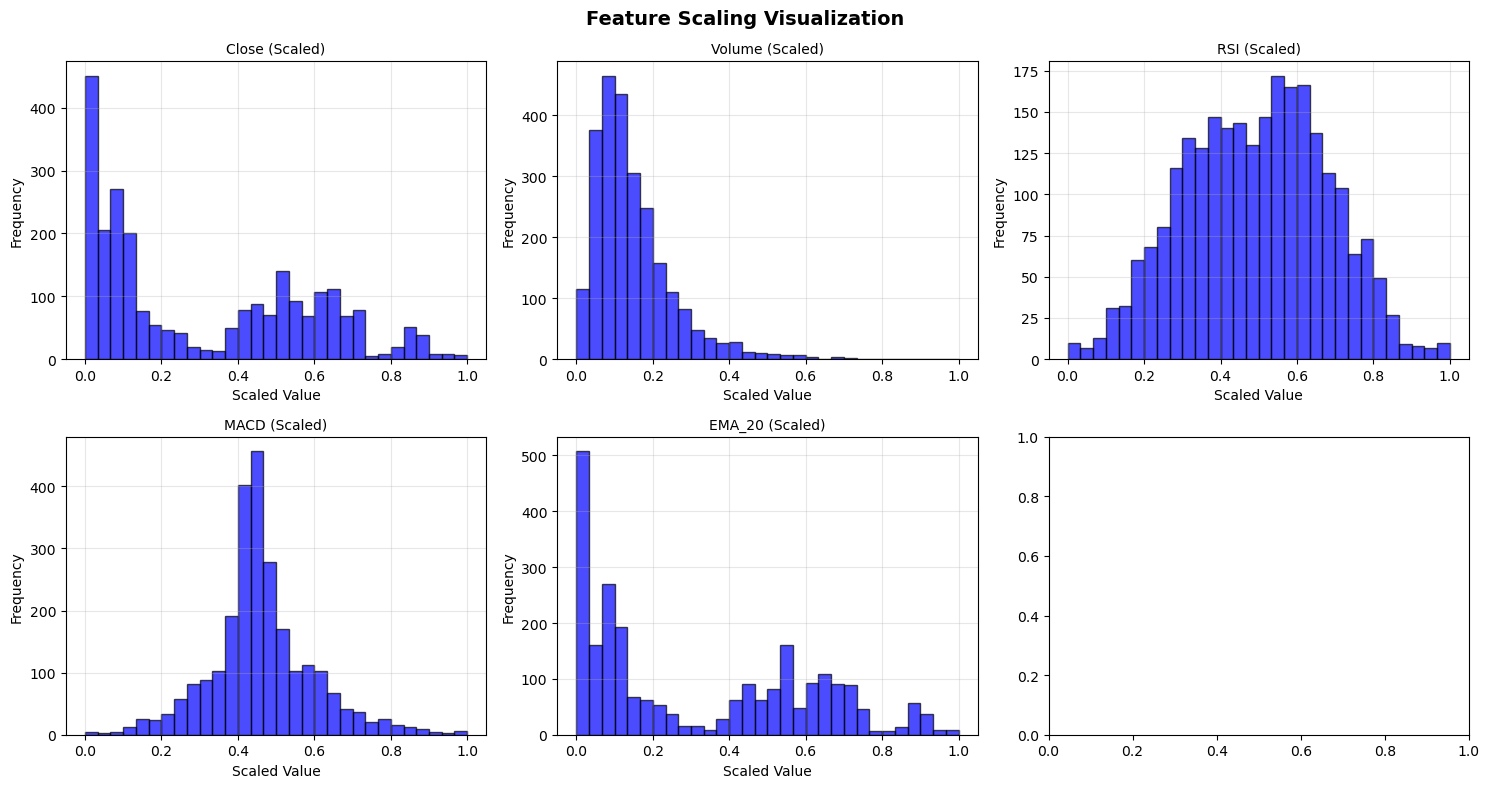

In [9]:

# Visualize scaling effect
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Feature Scaling Visualization', fontsize=14, fontweight='bold')

for i, feature in enumerate(FEATURES):
    row = i // 3
    col = i % 3
    axes[row, col].hist(scaled_features[:, i], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[row, col].set_title(f'{feature} (Scaled)', fontsize=10)
    axes[row, col].set_xlabel('Scaled Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 6: Sequence Generation


In [10]:
def create_sequences(features, target, window_size):
    """Create sequences for LSTM training."""
    X, y = [], []
    for i in range(window_size, len(features)):
        X.append(features[i-window_size:i])
        y.append(target[i])
    return np.array(X), np.array(y)

print("\n📦 Creating sequences...")
X, y = create_sequences(scaled_features, scaled_target.flatten(), WINDOW_SIZE)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Total sequences: {len(X)}")


📦 Creating sequences...
X shape: (2430, 60, 5)
y shape: (2430,)
Total sequences: 2430


In [11]:
# Chronological split
split_idx = int(len(X) * TRAIN_SPLIT_PERCENT)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTraining set: {X_train.shape[0]} sequences")
print(f"Test set: {X_test.shape[0]} sequences")
print(f"Train dates: {df_clean.index[WINDOW_SIZE]} to {df_clean.index[WINDOW_SIZE + split_idx - 1]}")
print(f"Test dates: {df_clean.index[WINDOW_SIZE + split_idx]} to {df_clean.index[-1]}")


Training set: 1944 sequences
Test set: 486 sequences
Train dates: 2015-05-06 00:00:00 to 2023-01-24 00:00:00
Test dates: 2023-01-25 00:00:00 to 2024-12-30 00:00:00


# Cell 7: Model Architecture


In [12]:
print("\n🏗️ Building LSTM model...")

model = Sequential([
    # First LSTM layer
    LSTM(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, NUM_FEATURES)),
    Dropout(0.2),
    
    # Second LSTM layer
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    
    # Dense layer
    Dense(units=32, activation='relu'),
    
    # Output layer
    Dense(units=1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')


🏗️ Building LSTM model...


In [13]:
print("\n📋 Model Summary:")
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")


📋 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,065 (129.16 KB)

 Trainable params: 33,065 (129.16 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 33,065


# Cell 8: Model Training


In [14]:
print("\n🚀 Training model...")
print(f"Training for {EPOCHS} epochs with batch size {BATCH_SIZE}")

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    shuffle=False,
    verbose=1
)

# Save model
model.save('lstm_model.h5')
print("\n✅ Model saved as 'lstm_model.h5'")


🚀 Training model...
Training for 50 epochs with batch size 32
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - loss: 0.1005 - val_loss: 0.0045
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.0086 - val_loss: 0.0049
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0086 - val_loss: 0.0041
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - loss: 0.0083 - val_loss: 0.0038
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.0062 - val_loss: 0.0032
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.0053 -


✅ Model saved as 'lstm_model.h5'


# Cell 9: Training History Visualization


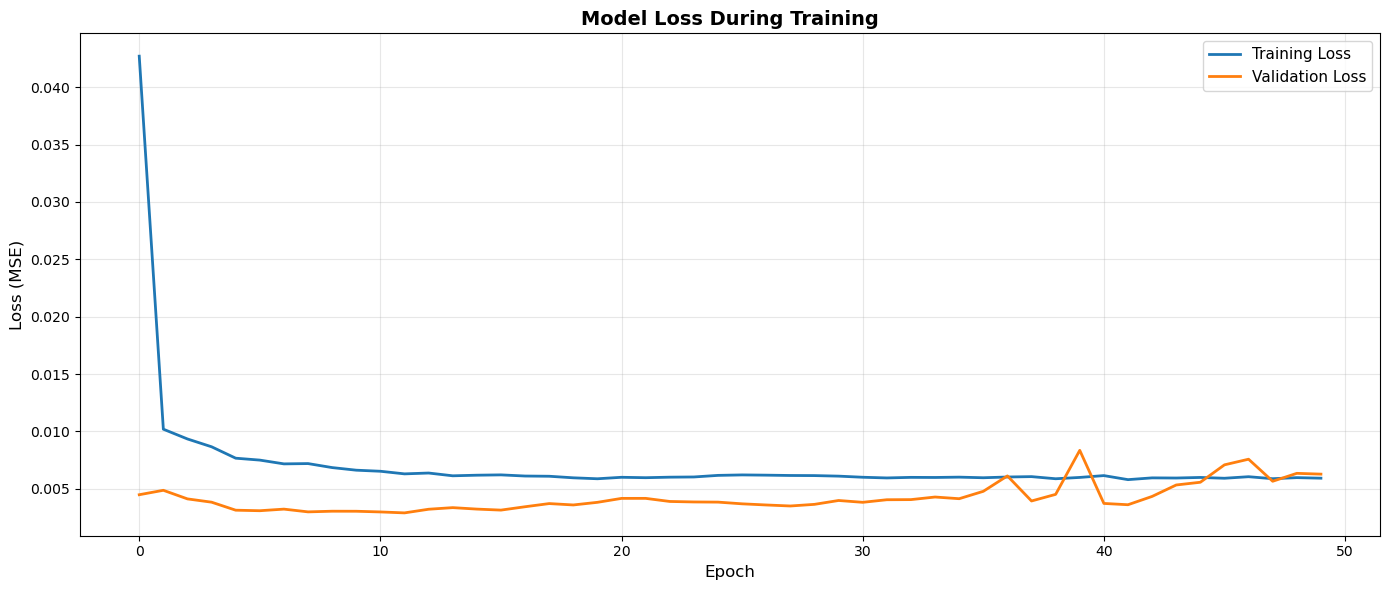

Final Training Loss: 0.005930
Final Validation Loss: 0.006282


In [15]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax.set_title('Model Loss During Training', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()

print(f"Final Training Loss: {history.history['loss'][-1]:.6f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.6f}")

In [16]:
# Cell 10: Model Evaluation


In [17]:
print("\n📊 Evaluating model...")

# Generate predictions
predictions_scaled = model.predict(X_test, verbose=0)

# Inverse transformation
predictions = scaler_target.inverse_transform(predictions_scaled)
actuals = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print("\n" + "=" * 80)
print("MODEL EVALUATION METRICS")
print("=" * 80)
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.6f}")
print(f"Mean Absolute Error (MAE): {np.mean(np.abs(actuals - predictions)):.6f}")
print("=" * 80)


📊 Evaluating model...

MODEL EVALUATION METRICS
Root Mean Squared Error (RMSE): 0.019884
R-squared (R²): -1.208279
Mean Absolute Error (MAE): 0.016145


# Cell 11: Prediction Visualization


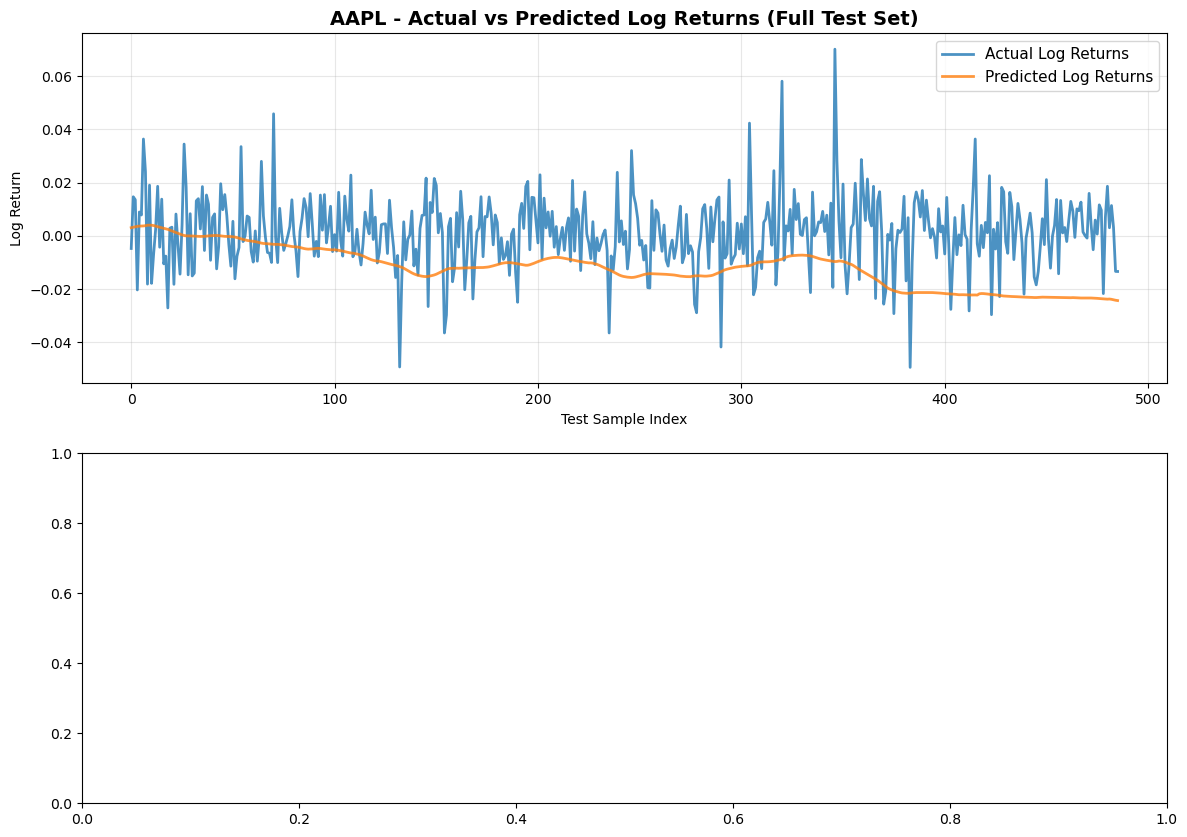

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full comparison
ax1.plot(actuals, label='Actual Log Returns', alpha=0.8, linewidth=2)
ax1.plot(predictions, label='Predicted Log Returns', alpha=0.8, linewidth=2)
ax1.set_title(f'{TICKER} - Actual vs Predicted Log Returns (Full Test Set)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Test Sample Index')
ax1.set_ylabel('Log Return')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

In [20]:
# Plot 2: Zoomed in (first 100 samples)
zoom_samples = min(100, len(actuals))
ax2.plot(actuals[:zoom_samples], label='Actual Log Returns', 
         alpha=0.8, linewidth=2, marker='o', markersize=4)
ax2.plot(predictions[:zoom_samples], label='Predicted Log Returns', 
         alpha=0.8, linewidth=2, marker='s', markersize=4)
ax2.set_title(f'Zoomed View - First {zoom_samples} Test Samples', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Test Sample Index')
ax2.set_ylabel('Log Return')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_plot.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

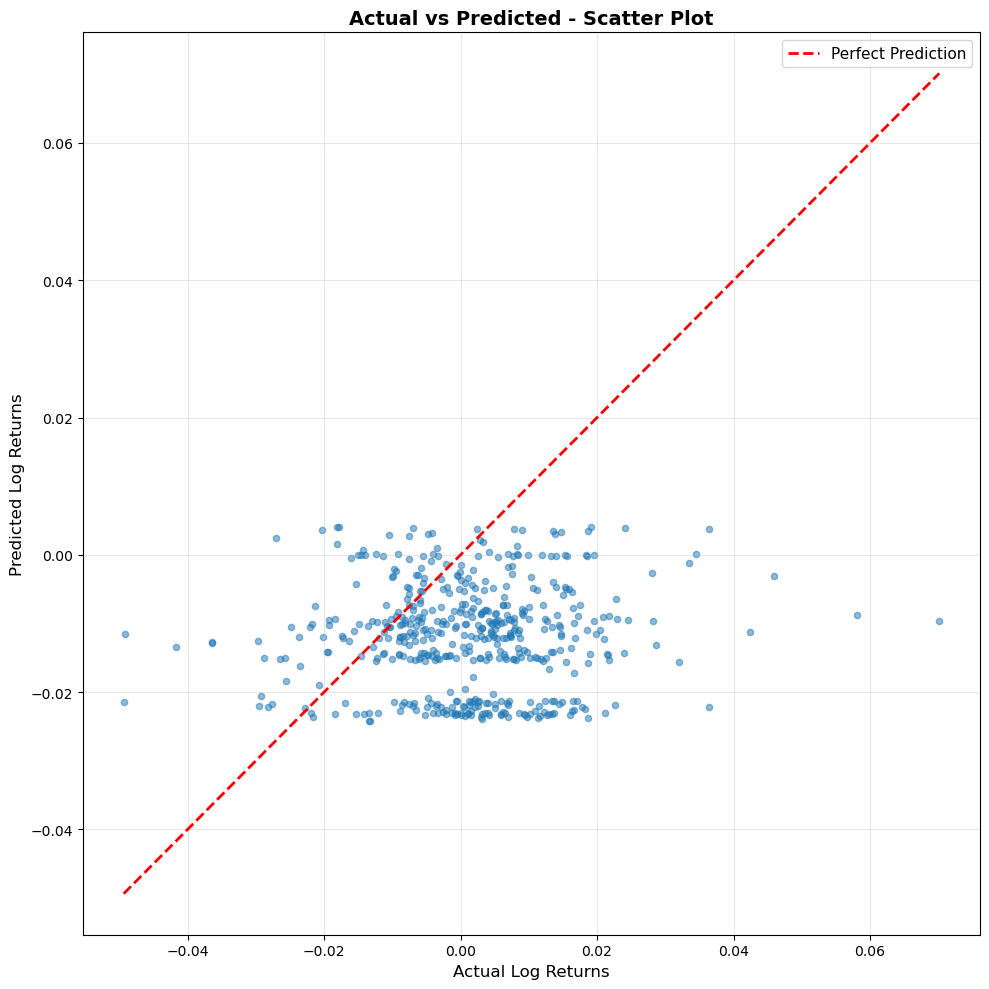

In [21]:
# Scatter plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(actuals, predictions, alpha=0.5, s=20)
ax.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 
        'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Log Returns', fontsize=12)
ax.set_ylabel('Predicted Log Returns', fontsize=12)
ax.set_title('Actual vs Predicted - Scatter Plot', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cell 12: Residual Analysis


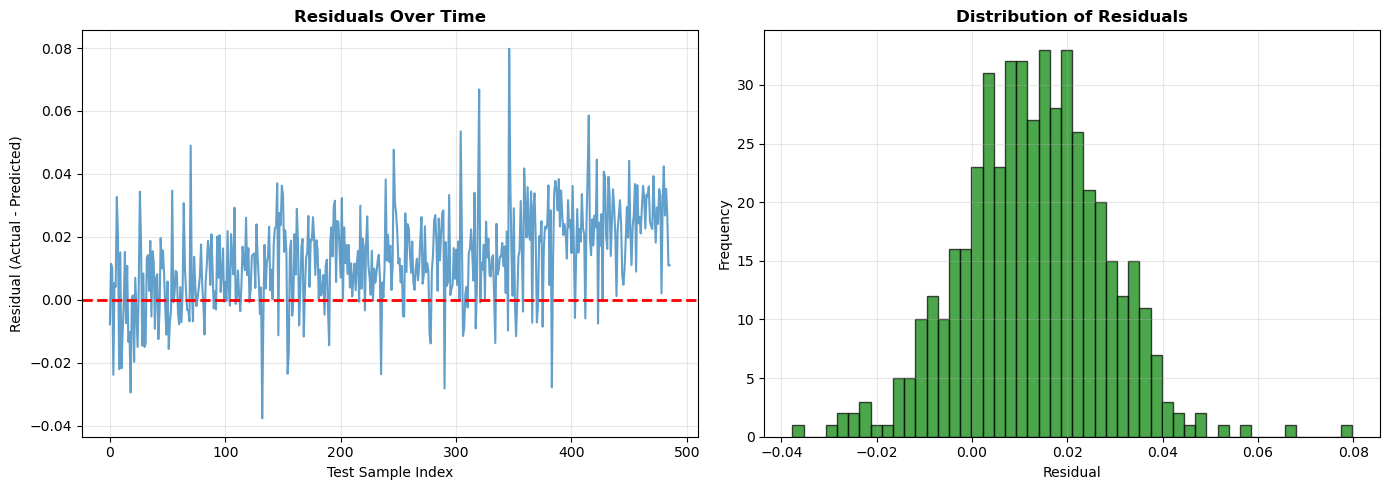

In [22]:
residuals = actuals.flatten() - predictions.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Residuals over time
ax1.plot(residuals, alpha=0.7)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax1.set_title('Residuals Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Test Sample Index')
ax1.set_ylabel('Residual (Actual - Predicted)')
ax1.grid(True, alpha=0.3)

# Residuals distribution
ax2.hist(residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
ax2.set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
ax2.set_xlabel('Residual')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:

print(f"\nResidual Statistics:")
print(f"Mean: {np.mean(residuals):.6f}")
print(f"Std Dev: {np.std(residuals):.6f}")
print(f"Min: {np.min(residuals):.6f}")
print(f"Max: {np.max(residuals):.6f}")


Residual Statistics:
Mean: 0.013032
Std Dev: 0.015018
Min: -0.037690
Max: 0.079767


# Cell 13: Future Price Prediction Function


In [25]:
def predict_future(model, scaler_features, scaler_target, df_clean, n_days=30):
    """Predict future stock prices using iterative forecasting."""
    print(f"\n🔮 Predicting next {n_days} days...")
    
    # Get last window
    last_window = df_clean[FEATURES].iloc[-WINDOW_SIZE:].values
    last_price = df_clean['Close'].iloc[-1]
    
    predicted_prices = [last_price]
    current_window = last_window.copy()
    
    for day in range(n_days):
        # Scale and predict
        scaled_window = scaler_features.transform(current_window)
        scaled_window_reshaped = scaled_window.reshape(1, WINDOW_SIZE, NUM_FEATURES)
        pred_scaled = model.predict(scaled_window_reshaped, verbose=0)
        pred_log_return = scaler_target.inverse_transform(pred_scaled)[0, 0]
        
        # Convert to price
        next_price = predicted_prices[-1] * np.exp(pred_log_return)
        predicted_prices.append(next_price)
        
        # Update window
        new_row = current_window[-1].copy()
        new_row[0] = next_price
        current_window = np.vstack([current_window[1:], new_row])
    
    return np.array(predicted_prices[1:])

# Cell 14: Generate and Visualize Future Predictions


In [26]:
# Predict next 30 days
future_days = 30
future_predictions = predict_future(model, scaler_features, scaler_target, df_clean, n_days=future_days)

print(f"\n✅ Generated {len(future_predictions)} day forecast")
print(f"Current price: ${df_clean['Close'].iloc[-1]:.2f}")
print(f"Predicted price (Day 1): ${future_predictions[0]:.2f}")
print(f"Predicted price (Day {future_days}): ${future_predictions[-1]:.2f}")
print(f"Total change: {((future_predictions[-1] / df_clean['Close'].iloc[-1] - 1) * 100):.2f}%")


🔮 Predicting next 30 days...

✅ Generated 30 day forecast
Current price: $251.31
Predicted price (Day 1): $245.26
Predicted price (Day 30): $122.69
Total change: -51.18%


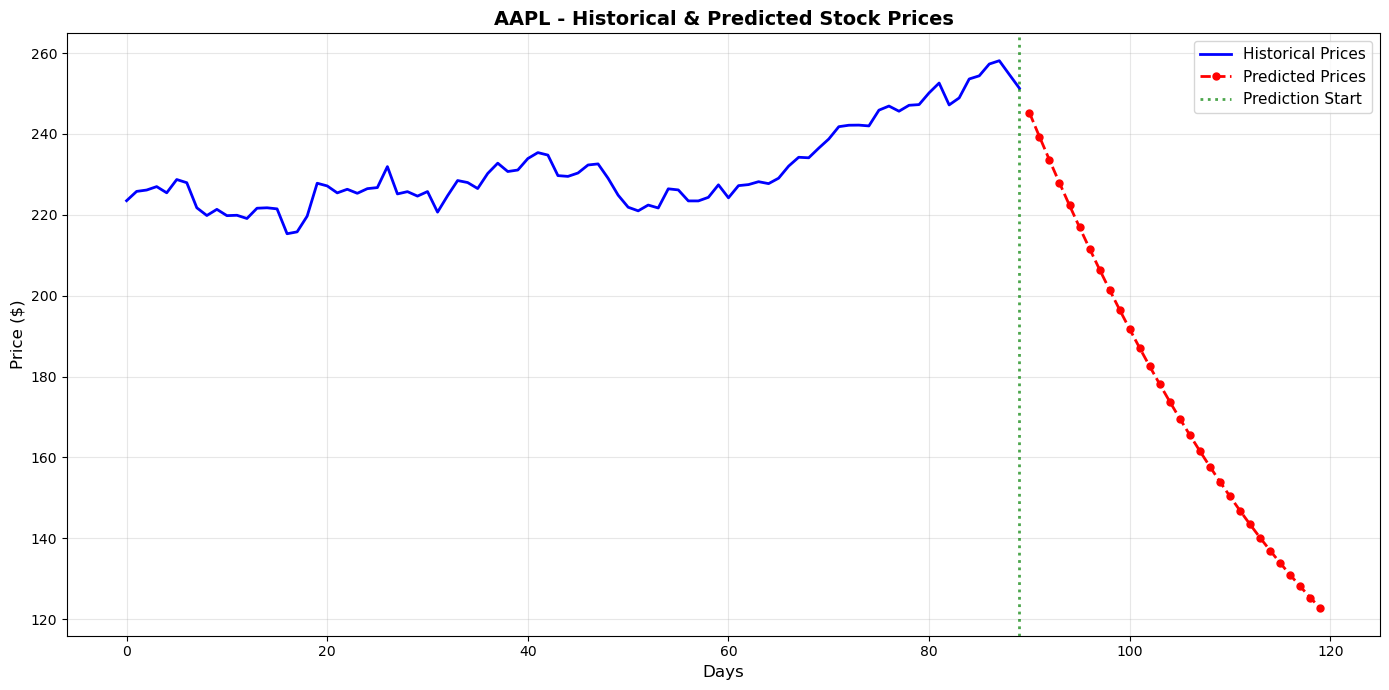

In [27]:
# Visualization
fig, ax = plt.subplots(figsize=(14, 7))

# Historical prices (last 90 days)
historical_days = 90
hist_data = df_clean['Close'].iloc[-historical_days:]
ax.plot(range(len(hist_data)), hist_data.values, 
        label='Historical Prices', linewidth=2, color='blue')

# Future predictions
future_x = range(len(hist_data), len(hist_data) + len(future_predictions))
ax.plot(future_x, future_predictions, 
        label='Predicted Prices', linewidth=2, color='red', linestyle='--', marker='o', markersize=5)

ax.axvline(x=len(hist_data)-1, color='green', linestyle=':', linewidth=2, alpha=0.7, label='Prediction Start')
ax.set_title(f'{TICKER} - Historical & Predicted Stock Prices', fontsize=14, fontweight='bold')
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# Create predictions DataFrame
pred_dates = pd.date_range(start=df_clean.index[-1] + pd.Timedelta(days=1), periods=future_days, freq='D')
pred_df = pd.DataFrame({
    'Date': pred_dates,
    'Predicted Price': future_predictions,
    'Change from Current': [(p / df_clean['Close'].iloc[-1] - 1) * 100 for p in future_predictions]
})

print("\nDetailed Predictions:")
display(pred_df.head(10))


Detailed Predictions:


,Date,Predicted Price,Change from Current
0,2024-12-31,245.257452,-2.407575
1,2025-01-01,239.334174,-4.764555
2,2025-01-02,233.538159,-7.070896
3,2025-01-03,227.868796,-9.326839
4,2025-01-04,222.325586,-11.532583
5,2025-01-05,216.908264,-13.688235
6,2025-01-06,211.616724,-15.793835
7,2025-01-07,206.450893,-17.849414
8,2025-01-08,201.410625,-19.855029
9,2025-01-09,196.495570,-21.810819


# Cell 15: Summary & Next Steps


In [29]:
print("\n" + "=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)
print("\n✅ Successfully completed all steps:")
print("  1. Data ingestion and feature engineering")
print("  2. Data preprocessing and scaling")
print("  3. Sequence generation")
print("  4. LSTM model training")
print("  5. Model evaluation")
print("  6. Future price prediction")
print("\n📁 Generated Artifacts:")
print("  - lstm_model.h5")
print("  - scaler_features.pkl")
print("  - scaler_target.pkl")
print("  - evaluation_plot.png")
print("  - training_history.png")
print("\n🚀 Next Steps:")
print("  - Run streamlit_app.py for interactive dashboard")
print("  - Experiment with different tickers")
print("  - Tune hyperparameters")
print("  - Add more features")
print("=" * 80)


PROJECT SUMMARY

✅ Successfully completed all steps:
  1. Data ingestion and feature engineering
  2. Data preprocessing and scaling
  3. Sequence generation
  4. LSTM model training
  5. Model evaluation
  6. Future price prediction

📁 Generated Artifacts:
  - lstm_model.h5
  - scaler_features.pkl
  - scaler_target.pkl
  - evaluation_plot.png
  - training_history.png

🚀 Next Steps:
  - Run streamlit_app.py for interactive dashboard
  - Experiment with different tickers
  - Tune hyperparameters
  - Add more features
